In [1]:
from Beamformer_MVDR import beamformer_MVDR
import utils
from acoular import MicGeom
import numpy as np
import os
from scipy import signal, stats
from pylab import axis, imshow, colorbar, show, title, savefig

# Parameters

INCREMENT = 0.5
isDiagonalLoading = False

test_name = "scan"
MIX_FILENAME = 'mix_mod_2_large.h5'
SIG_FILENAME = 'sig_mod_2_large.h5'
IAN_FILENAME = 'noise_mod_2_large.h5'
dir_path = './data'
MIX_FILENAME = os.path.join(dir_path, MIX_FILENAME)
SIG_FILENAME = os.path.join(dir_path, SIG_FILENAME)
IAN_FILENAME = os.path.join(dir_path, IAN_FILENAME)

OUTPUT_FOLDER = f'result_increment_{INCREMENT}'
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

RESULT_NAME = f'result_increment_source_{INCREMENT}.npy'
FIGURE_NAME = f'figure_increment_source_{INCREMENT}.epi'
RESULT_NAME = os.path.join(OUTPUT_FOLDER, RESULT_NAME)
FIGURE_NAME = os.path.join(OUTPUT_FOLDER, FIGURE_NAME)

mg = MicGeom(from_file='./array_geom/array_2_large.xml')
number_of_mic = mg.mpos.shape[1]
MIC_POS = []
for i in np.arange(number_of_mic):
    MIC_POS.append(mg.mpos[:,int(i)])

LOOK_POS = [0.8,2.3,0.5]
NOISE_POS = [3.2,2.2,0.5]
NOISE_CH = 1
SIG_CH = 0
# NOISE_POS = [0.8,2.3,0.5]
# LOOK_POS = [3.2,2.2,0.5]
# SIG_CH = 1
# NOISE_CH = 0
SAMPLING_RATE = 51200
FFT_LENGTH = 8192
FFT_SHIFT = 2048
SOUND_SPEED = 343

mvdr_beamformer = beamformer_MVDR(MIC_POS, sampling_rate=SAMPLING_RATE, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT, sound_speed=SOUND_SPEED)

In [2]:
### noise spectrogram multiplied with steering vector pointing to its position
multi_signal = utils.get_data_from_h5(MIX_FILENAME, skip_last_channel=False)
noise_signal = mvdr_beamformer.get_augmented_noise(NOISE_POS, multi_signal, NOISE_CH)

spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(noise_signal) # noise covariance matrix

steering_vector = mvdr_beamformer.get_steering_vector_near_field(LOOK_POS)

beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix, isDiagonalLoading)

complex_spectrum = utils.get_spectrogram(multi_signal, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)

enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

Health indicator for 850 modulation frequency

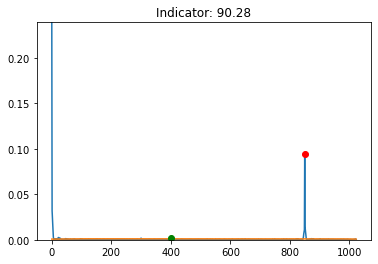

In [3]:
%matplotlib inline
from scipy import signal, stats
import matplotlib.pyplot as plt

enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT)
data = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7
# sampling_rate, data = wavfile.read("modulated_signal_noise.wav")

# t = np.arange(len(data)) / SAMPLING_RATE
f = np.linspace(0, SAMPLING_RATE, len(data))

analytic_signal = signal.hilbert(data)
amplitude_envelope = np.abs(analytic_signal)

ses = np.abs(np.fft.fft(amplitude_envelope) / len(data))
ses = ses[:int(len(data)/50)]
freqs = f[:int(len(data)/50)]

mod_freq = 850
ind_mod = (np.abs(freqs - mod_freq)).argmin()
noise_freq = 400
ind_mod_noise = (np.abs(freqs - noise_freq)).argmin()

thres1 = signal.medfilt(ses, 255)
thres2 = stats.median_abs_deviation(ses)
thres3 = thres1 + 6 * thres2

Indicator = round(ses[ind_mod] / thres3.mean(), 2) - round(ses[ind_mod_noise] / thres3.mean(), 2)

plt.title(f'Indicator: {Indicator}')
plt.plot(freqs, ses)
plt.plot(freqs, thres3)
plt.ylim(0,1*ses[0])
plt.plot(freqs[ind_mod], ses[ind_mod], 'ro')
plt.plot(freqs[ind_mod_noise], ses[ind_mod_noise], 'go')
savefig(f'./results/result_{test_name}_indicator.eps', format='eps')
plt.show()

3D plot

In [ ]:
# %matplotlib widget
# from acoular import RectGrid
# import matplotlib.pyplot as plt
# import multiprocessing
# from joblib import Parallel, delayed
# from tqdm import tqdm

# def getIndicator(look_pos):
#     steering_vector = mvdr_beamformer.get_steering_vector_near_field(look_pos)
#     beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix, isDiagonalLoading)
#     enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)
#     enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT)
#     data = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7
#     # t = np.arange(len(data)) / SAMPLING_RATE
#     f = np.linspace(0, SAMPLING_RATE, len(data))
#     analytic_signal = signal.hilbert(data)
#     amplitude_envelope = np.abs(analytic_signal)
#     ses = np.abs(np.fft.fft(amplitude_envelope) / len(data))
#     ses = ses[:int(len(data)/50)]
#     freqs = f[:int(len(data)/50)]
#     mod_freq = 850
#     ind_mod = (np.abs(freqs - mod_freq)).argmin()
#     # noise_freq = 400
#     # ind_mod_noise = (np.abs(freqs - noise_freq)).argmin()
#     thres1 = signal.medfilt(ses, 255)
#     thres2 = stats.median_abs_deviation(ses)
#     thres3 = thres1 + 6 * thres2
#     indi_temp = round(ses[ind_mod] / thres3.mean(), 2)
#     result = [look_pos[0], look_pos[1], indi_temp]
#     return indi_temp

# """
# define grid
# """
# rg = RectGrid( x_min=-0.2, x_max=4,
#                         y_min=-0.2, y_max=4,
#                         z=0.5, increment=1 )

# grid_points = int(np.sqrt(rg.gpos.shape[1]))

# myList = [rg.gpos[:,ind] for ind in np.arange(rg.gpos.shape[1])]

# num_cores = multiprocessing.cpu_count()
# inputs = tqdm(myList)

# processed_list = Parallel(n_jobs=num_cores)(delayed(getIndicator)(i) for i in inputs)

# results = np.array(processed_list)

# """
# plot beamformer
# """
# fig = plt.figure()
# ax3 = plt.axes(projection='3d')

# X_g = rg.gpos[0,:].reshape(grid_points,grid_points)
# Y_g = rg.gpos[1,:].reshape(grid_points,grid_points)
# Z_g = results.reshape(grid_points,grid_points)

# # ax3.scatter(noise_coord[0], noise_coord[1], np.min(Z_g), s=40, c='r', marker='x')
# # ax3.scatter(LOOK_POS[0], LOOK_POS[1], np.min(Z_g), s=40, c='g', marker='o')

# ax3.set_xlabel('$X (m)$')
# ax3.set_ylabel('$Y (m)$')
# ax3.set_zlabel('$Indicator$')

# ax3.plot_surface(X_g,Y_g,Z_g,cmap='rainbow')
# # ax3.contour(X_g,Y_g,Z_g, zdim='z',offset=np.min(Z_g), cmap='rainbow')

# plt.show()

2D plot: source location mismatch

100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


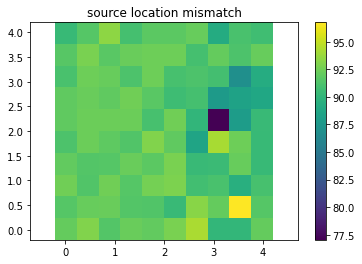

In [13]:
%matplotlib inline
from acoular import RectGrid
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm


mvdr_beamformer = beamformer_MVDR(MIC_POS, sampling_rate=SAMPLING_RATE, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT, sound_speed=SOUND_SPEED)
multi_signal = utils.get_data_from_h5(MIX_FILENAME, skip_last_channel=False)
noise_signal = mvdr_beamformer.get_augmented_noise(NOISE_POS, multi_signal, NOISE_CH)
spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(noise_signal) # noise covariance matrix

def getIndicator(look_pos):
    steering_vector = mvdr_beamformer.get_steering_vector_near_field(look_pos)
    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix, isDiagonalLoading)
    enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)
    enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT)
    data = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7
    # t = np.arange(len(data)) / SAMPLING_RATE
    f = np.linspace(0, SAMPLING_RATE, len(data))
    analytic_signal = signal.hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    ses = np.abs(np.fft.fft(amplitude_envelope) / len(data))
    ses = ses[:int(len(data)/50)]
    freqs = f[:int(len(data)/50)]
    mod_freq = 850
    ind_mod = (np.abs(freqs - mod_freq)).argmin()
    # noise_freq = 400
    # ind_mod_noise = (np.abs(freqs - noise_freq)).argmin()
    thres1 = signal.medfilt(ses, 255)
    thres2 = stats.median_abs_deviation(ses)
    thres3 = thres1 + 6 * thres2
    indi_temp = round(ses[ind_mod] / thres3.mean(), 2)
    # indi_temp2 = round(ses[ind_mod_noise] / thres3.mean(), 2)
    # indi_temp = indi_temp - indi_temp2
    # result = [look_pos[0], look_pos[1], indi_temp]
    return indi_temp

"""
define grid
"""
rg = RectGrid( x_min=-0.2, x_max=4.2,
                        y_min=-0.2, y_max=4.2,
                        z=0.5, increment=INCREMENT )

grid_points = int(np.sqrt(rg.gpos.shape[1]))

myList = [rg.gpos[:,ind] for ind in np.arange(rg.gpos.shape[1])]

num_cores = multiprocessing.cpu_count()
inputs = tqdm(myList)

processed_list = Parallel(n_jobs=num_cores)(delayed(getIndicator)(i) for i in inputs)

results = np.array(processed_list)

"""
plot beamformer
"""

Z_g = results.reshape(grid_points,grid_points)
# imshow( Z_g.T, origin='lower', extent=rg.extend(), interpolation='bicubic')
imshow( Z_g.T, origin='lower', extent=rg.extend())
colorbar()
axis('equal')
title('source location mismatch')
savefig(f'./results/result_{test_name}_source.eps', format='eps')
show()

2D plot: interference location mismatch

In [ ]:
%matplotlib inline
from acoular import RectGrid
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm


mvdr_beamformer = beamformer_MVDR(MIC_POS, sampling_rate=SAMPLING_RATE, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT, sound_speed=SOUND_SPEED)
multi_signal = utils.get_data_from_h5(MIX_FILENAME, skip_last_channel=False)
steering_vector = mvdr_beamformer.get_steering_vector_near_field(LOOK_POS)

def getIndicator2(noise_pos):
    noise_signal = mvdr_beamformer.get_augmented_noise(noise_pos, multi_signal, NOISE_CH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(noise_signal) # noise covariance matrix
    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix, isDiagonalLoading)
    enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)
    enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT)
    data = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7
    # t = np.arange(len(data)) / SAMPLING_RATE
    f = np.linspace(0, SAMPLING_RATE, len(data))
    analytic_signal = signal.hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    ses = np.abs(np.fft.fft(amplitude_envelope) / len(data))
    ses = ses[:int(len(data)/50)]
    freqs = f[:int(len(data)/50)]
    mod_freq = 850
    ind_mod = (np.abs(freqs - mod_freq)).argmin()
    # noise_freq = 400
    # ind_mod_noise = (np.abs(freqs - noise_freq)).argmin()
    thres1 = signal.medfilt(ses, 255)
    thres2 = stats.median_abs_deviation(ses)
    thres3 = thres1 + 6 * thres2
    indi_temp = round(ses[ind_mod] / thres3.mean(), 2)
    # result = [look_pos[0], look_pos[1], indi_temp]
    return indi_temp

"""
define grid
"""
rg = RectGrid( x_min=-0.2, x_max=4,
                        y_min=-0.2, y_max=4,
                        z=0.5, increment=INCREMENT )

grid_points = int(np.sqrt(rg.gpos.shape[1]))

myList = [rg.gpos[:,ind] for ind in np.arange(rg.gpos.shape[1])]

num_cores = multiprocessing.cpu_count()
inputs = tqdm(myList)

processed_list = Parallel(n_jobs=num_cores)(delayed(getIndicator2)(i) for i in inputs)

results = np.array(processed_list)

"""
plot beamformer
"""

Z_g = results.reshape(grid_points,grid_points)
# imshow( Z_g.T, origin='lower', extent=rg.extend(), interpolation='bicubic')
imshow( Z_g.T, origin='lower', extent=rg.extend())
colorbar()
axis('equal')
title('interference location mismatch')
savefig(f'./results/result_{test_name}_interference.eps', format='eps')
show()

Noise mismatch: fine search

In [ ]:
%matplotlib inline
from acoular import RectGrid
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm


mvdr_beamformer = beamformer_MVDR(MIC_POS, sampling_rate=SAMPLING_RATE, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT, sound_speed=SOUND_SPEED)
multi_signal = utils.get_data_from_h5(MIX_FILENAME, skip_last_channel=False)
steering_vector = mvdr_beamformer.get_steering_vector_near_field(LOOK_POS)

def getIndicator2(noise_pos):
    noise_signal = mvdr_beamformer.get_augmented_noise(noise_pos, multi_signal, NOISE_CH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(noise_signal) # noise covariance matrix
    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix, isDiagonalLoading)
    enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)
    enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT)
    data = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7
    # t = np.arange(len(data)) / SAMPLING_RATE
    f = np.linspace(0, SAMPLING_RATE, len(data))
    analytic_signal = signal.hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    ses = np.abs(np.fft.fft(amplitude_envelope) / len(data))
    ses = ses[:int(len(data)/50)]
    freqs = f[:int(len(data)/50)]
    mod_freq = 850
    ind_mod = (np.abs(freqs - mod_freq)).argmin()
    # noise_freq = 400
    # ind_mod_noise = (np.abs(freqs - noise_freq)).argmin()
    thres1 = signal.medfilt(ses, 255)
    thres2 = stats.median_abs_deviation(ses)
    thres3 = thres1 + 6 * thres2
    indi_temp = round(ses[ind_mod] / thres3.mean(), 2)
    # result = [look_pos[0], look_pos[1], indi_temp]
    return indi_temp

"""
define grid
"""
rg = RectGrid( x_min=3.5, x_max=4.5,
                        y_min=1.5, y_max=2.5,
                        z=0.5, increment=0.02 )

grid_points = int(np.sqrt(rg.gpos.shape[1]))

myList = [rg.gpos[:,ind] for ind in np.arange(rg.gpos.shape[1])]

num_cores = multiprocessing.cpu_count()
inputs = tqdm(myList)

processed_list = Parallel(n_jobs=num_cores)(delayed(getIndicator2)(i) for i in inputs)

results = np.array(processed_list)

"""
plot beamformer
"""

Z_g = results.reshape(grid_points,grid_points)
# imshow( Z_g.T, origin='lower', extent=rg.extend(), interpolation='bicubic')
imshow( Z_g.T, origin='lower', extent=rg.extend())
colorbar()
axis('equal')
title('interference mismatch: fine search')
savefig(f'./results/result_{test_name}_interference_fine_search.eps', format='eps')
show()

In [ ]:
import numpy as np

with open('result_increment_0.1.npy', 'rb') as f:
    a = np.load(f)
print(a)